In [ ]:
%%capture
!pip install transformers pymorphy2 torchmetrics wandb focal_loss_torch opencv-python nltk gdown pymorphy3 pymorphy3-dicts-ru

In [27]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.3.1 is successfully installed


In [20]:
%cd

/home/innodatahub


In [ ]:
!pip install gdown
!gdown 13X6J0enOo1m-MCbUvMt-lueWrdGXNnF0
!gdown 1HJqqXsw9OnM3nSRgAcqNy5ktqnqWPtfq
!gdown 1fkx3Hq0j0ItDz0z-OX36pAqFJ3k21NGm

In [80]:
import pandas as pd
import cv2
import os
import albumentations as A
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from collections import defaultdict
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from transformers import EfficientNetImageProcessor, EfficientNetForImageClassification
from transformers import AutoTokenizer, AutoModel
from collections import OrderedDict
from tqdm import tqdm
from sklearn.metrics import f1_score

In [2]:
torch.cuda.is_available()

True

In [3]:
def display_image(img):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    ax.set_axis_off()
    plt.show()

In [81]:
train_transform = A.Compose([
    A.SmallestMaxSize(max_size=224),
    A.RandomCrop(width=160, height=160, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

valid_transform = A.Compose([
    A.SmallestMaxSize(max_size=224),
    A.CenterCrop(width=160, height=160, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

In [82]:
#сперва обработаем картинки
label2id = ["Развлечения и юмор", "Кулинария", "Торговля и объявления", "СМИ", "Философия и религия", "Животные", "Творчество и дизайн", "Путешествия"]
class make_dataset_(Dataset):
  def __init__(self, data_df, path_to_data, transform, mode="train"):
    self.path_to_data = path_to_data
    self.data = data_df.copy()
    self.data["id"] = self.data["id"].apply(lambda x: os.path.join(path_to_data, str(x)))
    self.mode = mode
    self.transform = transform
  def __getitem__(self, id):
    to_tensor = ToTensorV2()
    img = cv2.imread(self.data.loc[id, "id"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = self.transform(image=img)["image"]
    img = to_tensor(image=cv2.resize(img, (224, 224)))["image"]
    if self.mode == "train":
      label = self.data.loc[id, "label"]
      return img, label2id.index(label)
    else:
      return img,
  def __len__(self):
    return len(self.data)

In [83]:
def train_valid_split(data, val_size):
    val_size = int(len(data) * val_size)
    train_size = len(data) - val_size
    return data[:train_size], data[train_size:]

In [84]:
%cd

/home/innodatahub


In [85]:
data = pd.read_csv("work/text_image_data/image_train.csv", sep=";")
data = data[data.label.isin(label2id)]
data.index = list(range(0, data.shape[0]))

train_df, valid_df = train_valid_split(data, 0.15)
valid_df.index = [i for i in range(len(valid_df))]
train_dset = make_dataset_(train_df, "work/text_image_data/data/Train", train_transform)
valid_dset = make_dataset_(valid_df, "work/text_image_data/data/Train", valid_transform)

<Axes: ylabel='Type'>

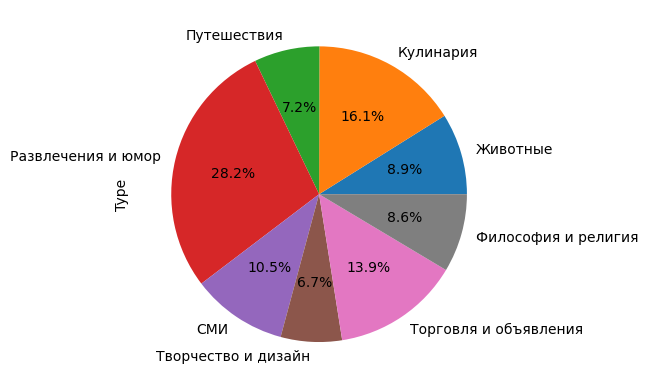

In [129]:
data.groupby("label").size().plot(kind='pie',
                                   y = "label",
                                   label = "Type",
                                   autopct='%1.1f%%')

In [86]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image.permute(1, 2, 0))
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


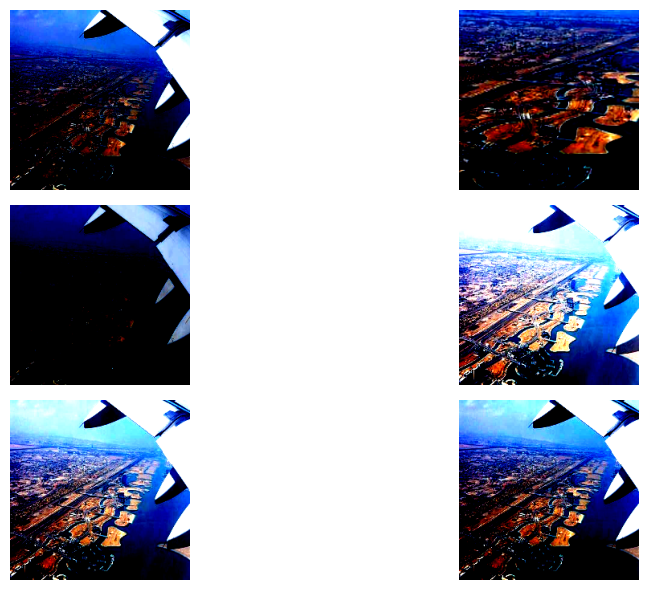

In [9]:
visualize_augmentations(train_dset, idx=345, samples=6, cols=2)

In [87]:
def calculate_accuracy(output, target):
    train_accuracy = torch.sum(target == output) / len(target)
    return train_accuracy

def calculate_f1(output, target):
    return f1_score(target.cpu(), output.cpu(), average="macro")

class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [123]:
model_image = EfficientNetForImageClassification.from_pretrained("google/efficientnet-b0")

model_image.classifier = nn.Sequential(OrderedDict([
    ("ln1", nn.Linear(1280, 640, bias=True)),
    ("dp2", nn.Dropout(p=0.1)),
    ("ln2", nn.Linear(640, 8, bias=True)),
    ("act2", nn.ReLU()),
]))

In [124]:
for p in model_image.parameters():
    p.requires_grad = False

for i in range(13, 16):
  for p in getattr(model_image.efficientnet.encoder.blocks, str(i)).parameters():
    p.requires_grad = True

was_true = 0
for p in model_image.parameters():
  if p.requires_grad == False and was_true == 0: continue
  elif p.requires_grad == True:
    was_true = 1
  else: p.requires_grad = True

In [125]:
params = {
    "lr": 3e-4,
    "batch_size": 32,
    "num_workers": 2,
    "epochs": 10,
    "device" : "cuda"
}

model = model_image.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

train_loader = DataLoader(
    train_dset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    valid_dset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [126]:
# from sklearn.metrics import f1_score
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images)["logits"]
        output = torch.nn.functional.softmax(output, dim=1)
        loss = criterion(output, target)
        output = torch.argmax(output, dim=1).to(torch.int64)
        accuracy = calculate_accuracy(output, target)
        f1 = calculate_f1(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        metric_monitor.update("F1", f1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [127]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images)["logits"]
            output = torch.nn.functional.softmax(output, dim=1)
            loss = criterion(output, target)
            output = torch.argmax(output, dim=1).to(torch.int64)
            accuracy = calculate_accuracy(output, target)
            f1 = calculate_f1(output, target)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            metric_monitor.update("F1", f1)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return metric_monitor.metrics["Loss"]["avg"]

In [128]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    loss = validate(val_loader, model, criterion, epoch, params)
    scheduler.step(loss)

Epoch: 1. Train.      Loss: 1.728 | Accuracy: 0.583 | F1: 0.433: 100%|██████████| 132/132 [01:58<00:00,  1.12it/s]
Epoch: 1. Validation. Loss: 1.627 | Accuracy: 0.643 | F1: 0.539: 100%|██████████| 24/24 [00:21<00:00,  1.12it/s]
Epoch: 2. Train.      Loss: 1.563 | Accuracy: 0.716 | F1: 0.646: 100%|██████████| 132/132 [01:57<00:00,  1.13it/s]
Epoch: 2. Validation. Loss: 1.607 | Accuracy: 0.663 | F1: 0.592: 100%|██████████| 24/24 [00:21<00:00,  1.10it/s]
Epoch: 3. Train.      Loss: 1.524 | Accuracy: 0.753 | F1: 0.684: 100%|██████████| 132/132 [01:56<00:00,  1.13it/s]
Epoch: 3. Validation. Loss: 1.583 | Accuracy: 0.685 | F1: 0.616: 100%|██████████| 24/24 [00:21<00:00,  1.14it/s]
Epoch: 4. Train.      Loss: 1.496 | Accuracy: 0.779 | F1: 0.709: 100%|██████████| 132/132 [01:57<00:00,  1.12it/s]
Epoch: 4. Validation. Loss: 1.568 | Accuracy: 0.705 | F1: 0.628: 100%|██████████| 24/24 [00:21<00:00,  1.13it/s]
Epoch: 5. Train.      Loss: 1.489 | Accuracy: 0.785 | F1: 0.723: 100%|██████████| 132/13

KeyboardInterrupt: 